In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Test rapide pour vérifier que ça fonctionne
print("Version de TensorFlow :", tf.__version__)

Version de TensorFlow : 2.16.2


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install xgboost --no-cache-dir

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


/opt/anaconda3/envs/tf_m1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
17:03:39 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing
2026-02-11 17:03:45.027212: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-02-11 17:03:45.027269: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-11 17:03:45.027290: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-11 17:03:45.027441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-11 17:03:45.027451: I tensorflow/core/common_runtime/pluggable_device/pluggable_devi

709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


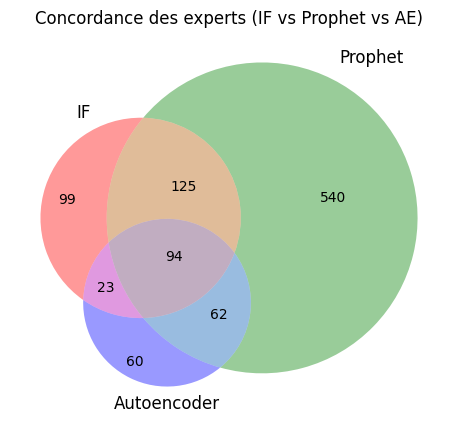

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from datetime import timedelta
import warnings

# --- SÉCURITÉ TENSORFLOW ---
# Vérifie si TensorFlow est installé pour entraîner un autoencoder.
# HAS_TF permet d’activer ou désactiver cette partie du code

HAS_TF = False
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Input
    HAS_TF = True
except:
    pass

warnings.filterwarnings('ignore')


# 1️⃣ PRÉPARATION DES DONNÉES

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url, parse_dates=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

ground_truth = [
    ("2013-12-10 06:25:00", "2013-12-12 05:35:00"), # Arrêt programmé
    ("2013-12-15 17:50:00", "2013-12-17 17:00:00"), # Panne capteur
    ("2014-01-27 14:15:00", "2014-01-29 13:45:00"), # Anomalie subtile
    ("2014-02-07 14:55:00", "2014-02-09 14:40:00")  # Panne critique
]

# Crée une colonne is_real_anomaly = 1 si la période est une anomalie connue, sinon 0.
# Sert de référence pour calculer précision et rappel des modèles.

df['is_real_anomaly'] = 0
for start, end in ground_truth:
    df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end), 'is_real_anomaly'] = 1

# Feature engeneering :
# hour → heure de la journée
# roll_mean → moyenne mobile sur 12 points
# roll_std → écart-type mobile sur 12 points
# temp_velocity → vitesse de variation de la température
# df_clean → supprime les lignes avec NaN
# Ces features permettent aux modèles d’avoir plus d’information sur le comportement temporel.

df["hour"] = df["timestamp"].dt.hour
df["roll_mean"] = df["value"].rolling(12).mean()
df["roll_std"] = df["value"].rolling(12).std()
df["temp_velocity"] = df["value"].diff().fillna(0)
df_clean = df.dropna().copy().reset_index(drop=True)



# 2️⃣ MODÉLISATION

scaler = StandardScaler()
features = ["value", "roll_mean", "roll_std", "temp_velocity", "hour"]
X_scaled = scaler.fit_transform(df_clean[features])
contam = 0.015

# Permet de lisser les anomalies sur plusieurs points
# Si une anomalie apparaît au moins window fois consécutives, on la considère persistante.

def apply_persistence(series, window=6):
    return (series.rolling(window=window).sum() >= window).astype(int)

# Isolation Forest, LOF & Prophet
# Détection d’anomalies non supervisée :
# IF → isole les points “étranges” dans les données
# LOF → compare densité locale pour identifier les points isolés
# Prophet est un modèle saisonnier pour séries temporelles.
# Ici, une anomalie est en dehors de l’intervalle de confiance (yhat_lower, yhat_upper).

df_clean["IF_anomaly"] = (IsolationForest(contamination=contam, random_state=42).fit_predict(X_scaled) == -1).astype(int)
df_clean["LOF_anomaly"] = (LocalOutlierFactor(n_neighbors=30, contamination=contam).fit_predict(X_scaled) == -1).astype(int)
m = Prophet(interval_width=0.98, daily_seasonality=True, weekly_seasonality=True).fit(df_clean[["timestamp","value"]].rename(columns={"timestamp":"ds","value":"y"}))
fc = m.predict(df_clean[["timestamp","value"]].rename(columns={"timestamp":"ds","value":"y"}))
df_clean["Prophet_anomaly"] = ((df_clean["value"] > fc["yhat_upper"].values) | (df_clean["value"] < fc["yhat_lower"].values)).astype(int)

# XGBoost
# XGBoost prédit la valeur normale.
# Si l’erreur prédiction > seuil (basé sur percentile), c’est une anomalie.
# On applique persistence pour lisser les détections.

reg = xgb.XGBRegressor(n_estimators=100).fit(df_clean[["roll_mean", "roll_std", "temp_velocity", "hour"]], df_clean["value"])
xgb_err = np.abs(df_clean["value"] - reg.predict(df_clean[["roll_mean", "roll_std", "temp_velocity", "hour"]])).rolling(12).mean().fillna(0)
df_clean["XGBoost_anomaly"] = apply_persistence((xgb_err > np.percentile(xgb_err, 100*(1-contam))).astype(int))

# Autoencoder (Deep Learning)
# Autoencoder reconstruit les features normales.
# Erreur de reconstruction élevée → anomalie.
# Lissage via rolling et persistence.

df_clean["AE_anomaly"] = 0
if HAS_TF:
    ae = Sequential([Input(shape=(len(features),)), Dense(16, activation='relu'), Dense(8, activation='relu'), Dense(16, activation='relu'), Dense(len(features), activation='linear')])
    ae.compile(optimizer='adam', loss='mse')
    ae.fit(X_scaled[df_clean['is_real_anomaly']==0], X_scaled[df_clean['is_real_anomaly']==0], epochs=20, verbose=0)
    ae_mse = np.mean(np.power(X_scaled - ae.predict(X_scaled), 2), axis=1)
    ae_smooth = pd.Series(ae_mse).rolling(12).mean().fillna(0).values
    df_clean["AE_anomaly"] = apply_persistence(pd.Series((ae_smooth > np.percentile(ae_smooth, 100*(1-contam))).astype(int)))

# IA Risk Score consolidé
# Combine les détections pour créer un score unique de risque
# Poids différents selon la fiabilité du modèle.

w = {'Prophet': 0.30, 'IF': 0.25, 'AE': 0.25, 'XGB': 0.10, 'LOF': 0.10} if HAS_TF else {'Prophet': 0.35, 'IF': 0.30, 'XGB': 0.20, 'LOF': 0.15}
df_clean['risk_score'] = (
    df_clean['Prophet_anomaly']*w.get('Prophet',0) + 
    df_clean['IF_anomaly']*w.get('IF',0) + 
    df_clean['XGBoost_anomaly']*w.get('XGB',0) + 
    df_clean['AE_anomaly']*w.get('AE',0) +
    df_clean['LOF_anomaly']*w.get('LOF',0)
) * 100


# =================================================================
# 3️⃣ VISUEL 1 : MONITORING INTEGRÉ & TABLEAU COMPLET (ACC + REC)
# =================================================================
fig1 = make_subplots(rows=2, cols=1, specs=[[{"type": "scatter"}], [{"type": "table"}]], row_heights=[0.7, 0.3], vertical_spacing=0.1)

fig1.add_trace(go.Scatter(x=df_clean['timestamp'], y=df_clean['value'], name='Température', line=dict(color='#D5DBDB')), row=1, col=1)
for start, end in ground_truth:
    fig1.add_vrect(x0=start, x1=end, fillcolor="red", opacity=0.1, layer="below", row=1, col=1)

# Couleurs et points pour CHAQUE modèle (incluant AE et LOF)
colors = {'IF_anomaly': '#E74C3C', 'Prophet_anomaly': '#2E86C1', 'XGBoost_anomaly': '#8E44AD', 'LOF_anomaly': '#F39C12', 'AE_anomaly': '#1ABC9C'}
models_list = [('IF', 'IF_anomaly'), ('Prophet', 'Prophet_anomaly'), ('LOF', 'LOF_anomaly'), ('XGBoost', 'XGBoost_anomaly')]
if HAS_TF: models_list.append(('Autoencoder', 'AE_anomaly'))

for name, col in models_list:
    m_df = df_clean[df_clean[col]==1]
    fig1.add_trace(go.Scatter(x=m_df['timestamp'], y=m_df['value'], mode='markers', name=name, marker=dict(color=colors[col], size=5)), row=1, col=1)

# Statistiques détaillées (Précision & Rappel)
actual_anomalies_count = df_clean['is_real_anomaly'].sum()
metrics = []
for name, col in models_list:
    tdet = df_clean[col].sum()
    hits = df_clean[(df_clean[col]==1) & (df_clean['is_real_anomaly']==1)].shape[0]
    metrics.append([name, int(tdet), int(hits), f"{(hits/tdet*100 if tdet>0 else 0):.1f}%", f"{(hits/actual_anomalies_count*100 if actual_anomalies_count>0 else 0):.1f}%"])

perf_tab = pd.DataFrame(metrics, columns=["Modèle", "Détections", "Vrais Positifs", "Précision", "Rappel"])
fig1.add_trace(go.Table(header=dict(values=[f"<b>{c}</b>" for c in perf_tab.columns], fill_color='#2C3E50', font=dict(color='white')),
                        cells=dict(values=[perf_tab[c] for c in perf_tab.columns], fill_color='#FBFCFC')), row=2, col=1)
fig1.update_layout(height=800, title="<b>1. ANALYSE MULTI-MODÈLES : DÉTECTIONS & MÉTRIQUES</b>", template="plotly_white")
fig1.show()

# =================================================================
# 4️⃣ VISUEL 2 : DASHBOARD DÉCISIONNEL (SIGNAL + IA SCORE)
# =================================================================
THRESHOLD_ALERTE = 25 
THRESHOLD_CRITIQUE = 50 

event_results = []
for i, (start, end) in enumerate(ground_truth):
    s_dt = pd.to_datetime(start)
    look = df_clean[(df_clean['timestamp'] >= s_dt - timedelta(hours=24)) & (df_clean['timestamp'] < s_dt)]
    alerts = look[look['risk_score'] >= THRESHOLD_ALERTE]
    status = "OUI ✅" if not alerts.empty else ("Pendant ⚠️" if df_clean[(df_clean['timestamp'] >= start) & (df_clean['timestamp'] <= pd.to_datetime(end))]['risk_score'].max() >= THRESHOLD_ALERTE else "NON ❌")
    lt = f"{s_dt - alerts['timestamp'].iloc[0]}" if not alerts.empty else "N/A"
    event_results.append([f"Panne n°{i+1}", status, lt])

fig2 = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05, 
                    specs=[[{"type": "scatter"}], [{"type": "scatter"}], [{"type": "table"}]], 
                    row_heights=[0.35, 0.40, 0.25], subplot_titles=("SIGNAL TEMPÉRATURE", "IA RISK SCORE (CONSENSUS)", "RAPPORTS D'ANTICIPATION MÉTIER"))

fig2.add_trace(go.Scatter(x=df_clean['timestamp'], y=df_clean['value'], name='Signal', line=dict(color='#BDC3C7', width=1)), row=1, col=1)
for start, end in ground_truth: fig2.add_vrect(x0=start, x1=end, fillcolor="red", opacity=0.1, row=1, col=1)

fig2.add_trace(go.Scatter(x=df_clean['timestamp'], y=df_clean['risk_score'], name='IA Score', line=dict(color='#2C3E50', width=2), fill='tozeroy', fillcolor='rgba(44, 62, 80, 0.1)'), row=2, col=1)
fig2.add_hline(y=THRESHOLD_ALERTE, line_dash="dash", line_color="#E67E22", annotation_text="ALERTE (25%)", row=2, col=1)
fig2.add_hline(y=THRESHOLD_CRITIQUE, line_dash="dot", line_color="#C0392B", annotation_text="CRITIQUE (50%)", row=2, col=1)

perf_df = pd.DataFrame(event_results, columns=["Événement", "Statut", "Anticipation"])
fig2.add_trace(go.Table(header=dict(values=[f"<b>{c}</b>" for c in perf_df.columns], fill_color='#34495E', font=dict(color='white')),
                        cells=dict(values=[perf_df[c] for c in perf_df.columns], fill_color='#FDFEFE')), row=3, col=1)

fig2.update_layout(height=1000, title_text="<b>2. SYSTÈME PRÉDICTIF : LEAD TIME & SÉCURITÉ</b>", template="plotly_white", showlegend=False)
fig2.show()

# =================================================================
# 5️⃣ VISUEL 3 : VENN DIAGRAM (CONCORDANCE DES EXPERTS)
# =================================================================
plt.figure(figsize=(8, 5))
venn3([set(df_clean.index[df_clean["IF_anomaly"]==1]),
       set(df_clean.index[df_clean["Prophet_anomaly"]==1]),
       set(df_clean.index[df_clean["AE_anomaly"]==1])],
      ('IF', 'Prophet', 'Autoencoder'))
plt.title("Concordance des experts (IF vs Prophet vs AE)")
plt.show()

In [10]:
df_clean.head()

,timestamp,value,is_real_anomaly,hour,roll_mean,roll_std,temp_velocity,IF_anomaly,LOF_anomaly,Prophet_anomaly,XGBoost_anomaly,AE_anomaly,risk_score
0,2013-12-02 22:10:00,79.508159,0,22,78.490194,2.269697,-1.275118,0,0,0,0,0,0.0
1,2013-12-02 22:15:00,79.302033,0,22,78.934753,1.770924,-0.206126,0,0,0,0,0,0.0
2,2013-12-02 22:20:00,80.802624,0,22,79.423648,1.318664,1.500591,0,0,0,0,0,0.0
3,2013-12-02 22:25:00,80.377789,0,22,79.778117,0.833592,-0.424835,0,0,0,0,0,0.0
4,2013-12-02 22:30:00,80.479237,0,22,79.972994,0.674089,0.101448,0,0,0,0,0,0.0


1. yhat : La valeur "idéale" (Prédiction) : 

C'est ce que le modèle considère comme la température normale attendue. Si on est lundi à 14h, yhat est la moyenne de ce que la machine a l'habitude de faire les lundis à 14h.
C'est la ligne centrale de ton tunnel.


2. upper : Le plafond (Borne supérieure) :

C'est la limite haute de l'intervalle de confiance (généralement réglé à 95% ou 98%). Le modèle dit : "Je pense que la valeur sera yhat, mais avec les variations naturelles, elle peut monter jusqu'à upper tout en restant normale." C'est le toit de ton tunnel.


3. lower : Le sol (Borne inférieure) : C'est la limite basse de l'intervalle de confiance. Le modèle dit : "La température peut descendre jusqu'à lower sans que je m'inquiète."
C'est le plancher de ton tunnel.





- Si valeur réelle > upper : La machine surchauffe anormalement par rapport à ses habitudes → Anomalie !

- Si valeur réelle < lower : La température chute de manière inexpliquée → Anomalie !

- Si la valeur est entre lower et upper : Tout va bien, on est à l'intérieur du tunnel.

In [11]:
# 1. Extraction des données de Prophet dans le format souhaité
df_prophet = pd.DataFrame({
    'timestamp': df_clean['timestamp'],
    'value': df_clean['value'],
    'yhat': fc['yhat'].values,
    'upper': fc['yhat_upper'].values,
    'lower': fc['yhat_lower'].values
})

# 2. Export en CSV
df_prophet.to_csv('df_prophet.csv', index=False)

df_prophet.head()

,timestamp,value,yhat,upper,lower
0,2013-12-02 22:10:00,79.508159,79.142673,109.349635,53.724237
1,2013-12-02 22:15:00,79.302033,79.156632,106.448437,54.068517
2,2013-12-02 22:20:00,80.802624,79.169121,105.896582,53.224317
3,2013-12-02 22:25:00,80.377789,79.180266,106.882677,50.484833
4,2013-12-02 22:30:00,80.479237,79.190190,107.133304,52.847766
